# **Iterative Customer Support Ticket Resolution Agent (LangGraph)**

## **Installing the dependencies**

In [1]:
!pip install langgraph langchain langchain_openai

  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.1
    Uninstalling langchain-core-1.2.1:
      Successfully uninstalled langchain-core-1.2.1


In [13]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [54]:
OPENAI_API_KEY = ''

## **Iterative workflow Langgraph**

In [40]:
classifier_llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)
generator_llm = ChatOpenAI(model="gpt-4o-mini",api_key=OPENAI_API_KEY)
evaluator_llm = ChatOpenAI(model="gpt-4o-mini",api_key=OPENAI_API_KEY)
optimizer_llm = ChatOpenAI(model="gpt-4o-mini",api_key=OPENAI_API_KEY)

In [41]:
from pydantic import BaseModel, Field

class TicketEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the ticket.")

In [42]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TicketEvaluation)

**State**

In [43]:
#state
class TicketState(TypedDict):
  ticket_text: str
  category: str
  draft_reply: str
  evaluation: Literal["approved", "needs_improvement"]
  feedback: str
  iteration: int
  max_iteration:int

  ticket_history: Annotated[list[str], operator.add]
  draft_history: Annotated[list[str], operator.add]

**Issue Classification**

In [44]:
def classify_issue(state: TicketState):

  messages = [
        SystemMessage(content="You are a ticket issue classifier."),
        HumanMessage(content=f"""
Write down what type of the issue is this: "{state['ticket_text']}".

Rules:
-classify the issue
-analyze the issue clearly
-return the category of the ticket-text

""")
    ]

  #send message to Issue Classifier
  response = classifier_llm.invoke(messages).content

  return  {'category': response, 'ticket_history': [response]}

**Ticket Draft Reply Generation**

In [45]:
def response_ticket(state: TicketState):

  messages = [
        SystemMessage(content="You are a best response generator based on issue category"),
        HumanMessage(content=f"""
Write down polite message to this issue: "{state['category']}".

Rules:
-cresponse politely to this particular issue
-analyze the issue clearly
-return the best draft reply to the issue person

""")
    ]

  #send message to Issue Classifier
  response = generator_llm.invoke(messages).content

  return  {'draft_reply': response, 'draft_history': [response]}

**Evaluate the response**

In [46]:
def evaluate_response(state: TicketState):

  messages = [
        SystemMessage(content="You are a best evaluator. Evaluate the response"),
        HumanMessage(content=f"""
evaluate this draft reply : "{state['draft_reply']}".

Rules:
    -classify the draft to check is it clear
    -check it is understandable
    -having a easy wording for reader
    -having somehow solution if possible

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"
- feedback: One paragraph explaining the strengths and weaknesses

""")
    ]

  #send message to Issue Classifier
  response = structured_evaluator_llm.invoke(messages)

  return {'evaluation':response.evaluation, 'feedback': response.feedback, 'draft_history': [response.feedback]}

In [47]:
def optimize_response(state: TicketState):
    messages = [
        SystemMessage(content="You punch up ticket text for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['ticket_text']}"
Original ticket topic:
{state['ticket_text']}

Re-write it as a well as best draft response..
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'ticket_text': response, 'iteration': iteration, 'ticket_history': [response]}

In [48]:
def route_evaluation(state: TicketState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

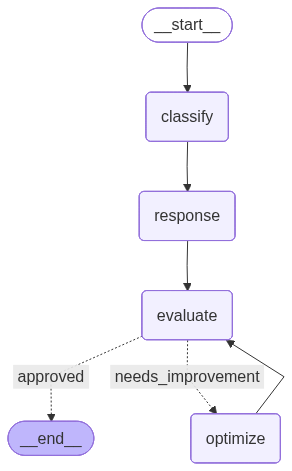

In [49]:
#define the graph
graph = StateGraph(TicketState)
graph.add_node('classify', classify_issue)
graph.add_node('response',response_ticket)
graph.add_node('evaluate', evaluate_response)
graph.add_node('optimize',optimize_response)


graph.add_edge(START, 'classify')
graph.add_edge('classify', 'response')
graph.add_edge('response', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()
workflow


In [52]:
initial_state = {
    "ticket_text": """Hi Support Team,

I’m unable to log into my account since yesterday. Every time I enter the correct email and password, it shows “authentication failed”. I tried resetting my password twice, but the issue is still there. This is urgent because I need to access my dashboard for a client demo today.

Please resolve this as soon as possible.

Thanks,
Ahmed""",

    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [53]:
result

{'ticket_text': 'Hi Support Team,\n\nI’m unable to log into my account since yesterday. Every time I enter the correct email and password, it shows “authentication failed”. I tried resetting my password twice, but the issue is still there. This is urgent because I need to access my dashboard for a client demo today.\n\nPlease resolve this as soon as possible.\n\nThanks,\nAhmed',
 'category': '**Issue Category:** Account Access/Authentication Issue\n\n**Issue Analysis:** \nThe user, Ahmed, is experiencing difficulties logging into his account. Despite entering the correct credentials, he encounters an "authentication failed" message. He has already attempted to reset his password twice, but the problem persists. This issue is urgent for Ahmed because he needs access to his account dashboard for an upcoming client demonstration.\n\n**Conclusion:** The ticket falls under the category of an account access or authentication issue, likely related to login credentials or account status.',
 'd